In [3]:
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from keras import applications
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datasetpath = 'dataset'
batch_size = 16
img_size = 128
model = applications.VGG16(include_top=False, weights='imagenet')

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.2)

train_generator = vgg_data_gen.flow_from_directory(
        datasetpath,
        subset="training",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False)  

cnn_features = model.predict_generator(train_generator, len(train_generator))

filename = 'cnn_features_training'
with open(filename, 'wb') as f:
          np.save(f, cnn_features)

val_generator = vgg_data_gen.flow_from_directory(
        datasetpath,
        subset="validation",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
cnn_features = model.predict_generator(val_generator, len(val_generator))
filename = 'cnn_features_validation'
with open(filename, 'wb') as f:
          np.save(f, cnn_features)


Found 2496 images belonging to 4 classes.
Found 623 images belonging to 4 classes.


In [14]:
from keras.utils.np_utils import to_categorical

datagen_top = ImageDataGenerator(rescale=1. / 255)
    
nb_train_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)

np.save('class_indices.npy', train_generator.class_indices)
with open('cnn_features_training', 'rb') as f:
    train_data = np.load(f)

train_labels = train_generator.classes

train_labels = to_categorical(train_labels, num_classes=num_classes)

nb_validation_samples = len(val_generator.filenames)

with open('cnn_features_validation', 'rb') as f:
    validation_data = np.load(f)
    
validation_labels = val_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4)


history = model.fit(train_data, train_labels,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    callbacks=[early_stopping]
                    )


Train on 2496 samples, validate on 623 samples
Epoch 1/50
2496/2496 [==============================] - 10s 4ms/step - loss: 8.4507 - acc: 0.4499 - val_loss: 5.0072 - val_acc: 0.6742
Epoch 2/50
2496/2496 [==============================] - 9s 4ms/step - loss: 6.2961 - acc: 0.5950 - val_loss: 4.4889 - val_acc: 0.7111
Epoch 3/50
2496/2496 [==============================] - 9s 4ms/step - loss: 5.2610 - acc: 0.6639 - val_loss: 2.6394 - val_acc: 0.8331
Epoch 4/50
2496/2496 [==============================] - 9s 4ms/step - loss: 4.7170 - acc: 0.6991 - val_loss: 2.7473 - val_acc: 0.8218
Epoch 5/50
2496/2496 [==============================] - 10s 4ms/step - loss: 4.4245 - acc: 0.7171 - val_loss: 2.4903 - val_acc: 0.8315
Epoch 6/50
2496/2496 [==============================] - 9s 4ms/step - loss: 4.0261 - acc: 0.7416 - val_loss: 3.3901 - val_acc: 0.7849
Epoch 7/50
2496/2496 [==============================] - 9s 4ms/step - loss: 3.8486 - acc: 0.7536 - val_loss: 3.3575 - val_acc: 0.7865
Epoch 8/50
24

623/623 [==============================] - 0s 349us/step
[INFO] accuracy: 82.83%
[INFO] Loss: 2.703036560292803


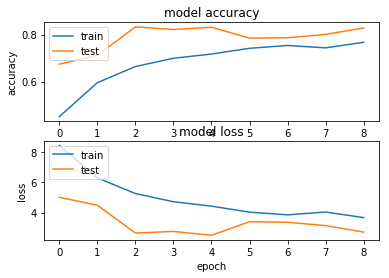

In [15]:
(eval_loss, eval_accuracy) = model.evaluate(
   validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

plt.figure(1)

    # summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()